In [156]:
!pip install yahoo_fin
from yahoo_fin.stock_info import get_data
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np
from sklearn.svm import SVR
from matplotlib import pyplot as plt
import datetime


# insert stock ticker name here for desired stock
stock_name = "aapl"
begin_date = "04/30/21"
year = 365

date_1 = datetime.datetime.strptime(begin_date, "%m/%d/%y")
end_date = date_1 + datetime.timedelta(days=year+50) #adjust for how long to train/test for
                                                    #if its too long, model will overfit
                                                    # if it overfits, 10 day predictions won't be good predictions

stock = get_data(stock_name, start_date=begin_date, end_date=f'{end_date.month}/{end_date.day}/{end_date.year}', index_as_date = True, interval="1d")
stock.dropna(inplace=True)
stock = stock.to_numpy()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [157]:
scaler = MinMaxScaler(feature_range=(0,1))
# scaler = StandardScaler()

# creates dataset of time_step previous closing prices to predict the next closing price

def create_dataset(dataset, time_step=10):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]  
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

# close prices in index 4 of the stock data
close_prices = stock[:,4]

train_size = int(close_prices.shape[0] * 0.8)


# scales training data and testing data separately
train_data = scaler.fit_transform(close_prices[:train_size].reshape(-1, 1))
test_data = scaler.fit_transform(close_prices[train_size:].reshape(-1, 1))


time_step = 20
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)


In [158]:
from sklearn.model_selection import GridSearchCV

# hyperparameter tuning to ensure best results

params = {'kernel': ("linear", 'rbf', 'sigmoid'), "C": (0.1, 1, 10, 100), "gamma": ("scale", "auto", 0.1, 0.2)}
grid = GridSearchCV(SVR(), params)
grid.fit(X_train, y_train)
print(grid.best_params_)

{'C': 1, 'gamma': 'scale', 'kernel': 'linear'}


0.5844594645182343


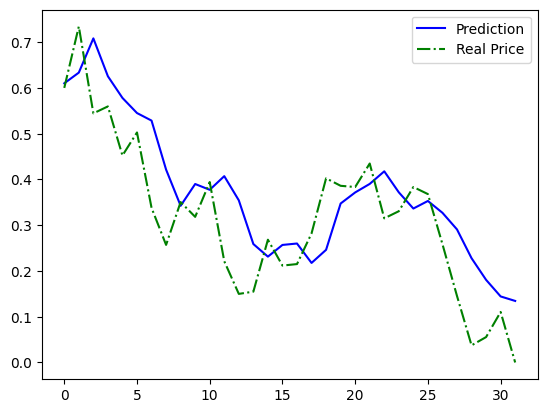

In [159]:
svr = SVR(kernel=grid.best_params_["kernel"], C=grid.best_params_["C"], gamma=grid.best_params_["gamma"]).fit(X_train, y_train)
# svr = SVR(kernel="linear", C=100, gamma="scale").fit(X_train, y_train)
print(svr.score(X_test, y_test))

# plotting predicted closing price against real closing price
pred = svr.predict(X_test)
x = [i for i in range(pred.shape[0])]
plt.plot(x, pred, "b")
plt.plot(x, y_test, "g-.")
plt.legend(["Prediction", "Real Price"])
plt.show()

In [160]:
print(svr.coef_)
# highly weighted on the final day, is almost a day offset of the real data
# hyperparameters need good regularization to account for this, as the model
# won't have access to the "real data" when giving its 10 day prediciton

[[-0.02712674 -0.00067347 -0.04472829  0.01613092  0.01526022  0.04644264
   0.1032317   0.01826196 -0.12374891 -0.0734169   0.00244662  0.00800841
   0.04456669  0.0602294   0.08133787 -0.04423886  0.0314823   0.00427464
  -0.01922381  0.03926603 -0.00194437  0.0954185   0.0484712   0.19201892
   0.54030165]]


In [161]:
# function to create next days predictions
# uses last 10 days of test data, then predicts and adds closing price to input
# takes off first index, repeats for pred_days

def predict(pred_days, model):
  x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
  temp_input=list(x_input)
  temp_input=temp_input[0].tolist()


  lst_output=[]
  n_steps=time_step
  for i in range(pred_days):    
      if(len(temp_input)>time_step):
          
          x_input=np.array(temp_input[1:])
          x_input=x_input.reshape(1,-1)
          
          yhat = model.predict(x_input)
          temp_input.extend(yhat.tolist())
          temp_input=temp_input[1:]
        
          lst_output.extend(yhat.tolist())
          
      else:
          yhat = model.predict(x_input)
          
          temp_input.extend(yhat.tolist())
          lst_output.extend(yhat.tolist())
          

  last_days=np.arange(1,time_step+1)
  day_pred=np.arange(time_step+1,time_step+pred_days+1)
  return last_days, day_pred, lst_output

/usr/local/lib/python3.9/dist-packages/yahoo_fin/stock_info.py:35: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  start_seconds = int(pd.Timestamp(start_date).timestamp())


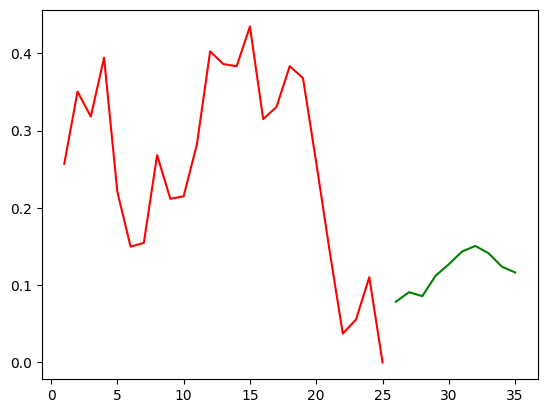

In [162]:

pred_days = 10
last_days, day_pred, lst_output = predict(pred_days, svr)

# get real data for next few days. Won't work if predicting for today, this is
# to test how our models predictions work feeding back into itself
next_begin = end_date + datetime.timedelta(days=1)
next_end = next_begin + datetime.timedelta(days=pred_days*2)

next_days = get_data(stock_name, start_date=f'{next_begin.day}/{next_begin.month}/{next_begin.year}', end_date=f'{next_end.day}/{next_end.month}/{next_end.year}', index_as_date = True, interval="1d").to_numpy()
next_stock = next_days[:pred_days, 4]

# last = scaler.inverse_transform(y_test.reshape(-1, 1))[-time_step:]
last = stock[-time_step:,4]
# next = scaler.inverse_transform(np.array(lst_output).reshape(-1, 1))
last = y_test[-time_step:]
next = lst_output
# next_stock = scaler.fit_transform(next_stock.reshape(-1, 1))

plt.plot(last_days, last, "r")
plt.plot(day_pred, next, "g")
# plt.plot(day_pred, next_stock, "b")
plt.show()

In [163]:
next_few_days_pred = ["buy" if next[i] < next[i+1] else "sell" for i in range(pred_days-1)]
next_few_days_pred = ["buy" if last[-1] < next[0] else "sell"] + next_few_days_pred

nfd_real = ["buy" if next_stock[i] < next_stock[i+1] else "sell" for i in range(pred_days-1)]
nfd_real = ["buy" if y_test[-1] < next_stock[0] else "sell"] + nfd_real

# comparing on a more classification basis, if the prediction and real data happen to at least 
# overlap here if the closing price was higher or lower than the day before

for i in range(len(nfd_real)):
  print("Day:", i+1, " "*(10-len(str(i+1))) + "Pred:", next_few_days_pred[i], "\tReal:", nfd_real[i], "\t", next_few_days_pred[i]==nfd_real[i] )

Day: 1          Pred: buy 	Real: buy 	 True
Day: 2          Pred: buy 	Real: sell 	 False
Day: 3          Pred: sell 	Real: buy 	 False
Day: 4          Pred: buy 	Real: buy 	 True
Day: 5          Pred: buy 	Real: sell 	 False
Day: 6          Pred: buy 	Real: sell 	 False
Day: 7          Pred: buy 	Real: buy 	 True
Day: 8          Pred: sell 	Real: sell 	 True
Day: 9          Pred: sell 	Real: buy 	 False
Day: 10         Pred: sell 	Real: buy 	 False


0.5843404860440478


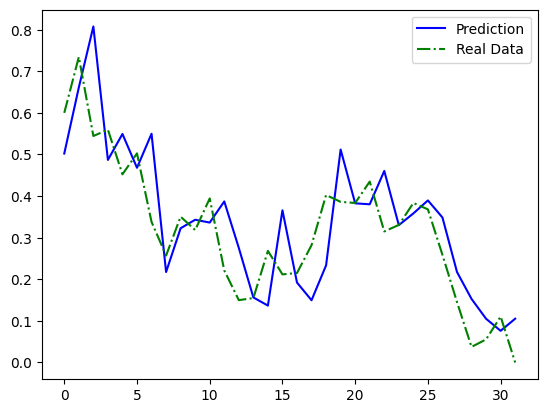

In [164]:
from sklearn.linear_model import LinearRegression 

lr = LinearRegression().fit(X_train, y_train)
print(lr.score(X_test, y_test))

# repeat what was done above with SVR with a Linear Regression model

pred = lr.predict(X_test)
x = [i for i in range(pred.shape[0])]
plt.plot(x, pred, "b")
plt.plot(x, y_test, "g-.")
plt.legend(["Prediction", "Real Data"])
plt.show()

In [165]:
print(lr.coef_)

[-0.06112884  0.05422207 -0.08460746  0.07206017  0.171388   -0.24026414
  0.13536661  0.15298547 -0.17056593 -0.10861668  0.01923895  0.12311249
 -0.18532073 -0.00484087  0.2442716  -0.11499686  0.14750171 -0.1917358
  0.07336645 -0.18905213  0.19516337  0.02707707 -0.01757771 -0.18691211
  1.11992232]


/usr/local/lib/python3.9/dist-packages/yahoo_fin/stock_info.py:35: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  start_seconds = int(pd.Timestamp(start_date).timestamp())


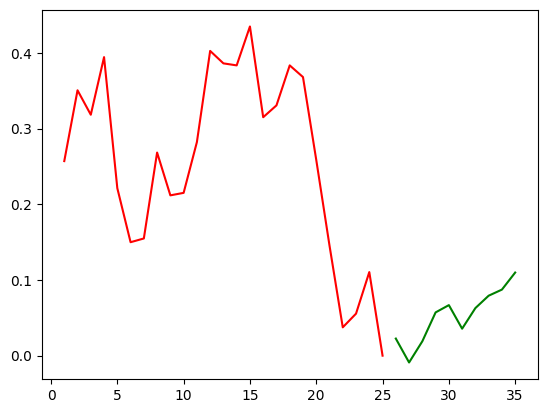

In [166]:
pred_days = 10
last_days, day_pred, lst_output = predict(pred_days, lr)

next_days = get_data(stock_name, start_date=f'{next_begin.day}/{next_begin.month}/{next_begin.year}', end_date=f'{next_end.day}/{next_end.month}/{next_end.year}', index_as_date = True, interval="1d").to_numpy()
next_stock = next_days[:pred_days, 4]

# last = scaler.inverse_transform(y_test[-time_step:].reshape(-1, 1))
# next = scaler.inverse_transform(np.array(lst_output).reshape(-1, 1))
last = y_test[-time_step:]
next = lst_output
# next_stock = scaler.fit_transform(next_stock.reshape(-1, 1))

plt.plot(last_days, last, "r")
plt.plot(day_pred, next, "g")
# plt.plot(day_pred, next_stock, "b")
plt.show()

In [167]:
next_few_days_pred = ["buy" if next[i] < next[i+1] else "sell" for i in range(pred_days-1)]
next_few_days_pred = ["buy" if last[-1] < next[0] else "sell"] + next_few_days_pred

nfd_real = ["buy" if next_stock[i] < next_stock[i+1] else "sell" for i in range(pred_days-1)]
nfd_real = ["buy" if y_test[-1] < next_stock[0] else "sell"] + nfd_real

for i in range(len(nfd_real)):
  print("Day:", i+1, " "*(10-len(str(i+1))) + "Pred:", next_few_days_pred[i], "\tReal:", nfd_real[i], "\t", next_few_days_pred[i]==nfd_real[i] )


Day: 1          Pred: buy 	Real: buy 	 True
Day: 2          Pred: sell 	Real: sell 	 True
Day: 3          Pred: buy 	Real: buy 	 True
Day: 4          Pred: buy 	Real: buy 	 True
Day: 5          Pred: buy 	Real: sell 	 False
Day: 6          Pred: sell 	Real: sell 	 True
Day: 7          Pred: buy 	Real: buy 	 True
Day: 8          Pred: buy 	Real: sell 	 False
Day: 9          Pred: buy 	Real: buy 	 True
Day: 10         Pred: buy 	Real: buy 	 True
